## DCGAN
- 현재 대부분의 GAN 모델이 DCGAN을 기반으로 만들어짐
- 합성곱 신경망과 전치 합성곱 신경망을 사용

## 배운 점
- ImageFolder 클래스는 데이터셋의 최상위 폴더에 서브폴더 요구하므로 이전 폴더 path로 설정해야함

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# setting
# 데이터셋의 경로
dataroot = r'C:\Users\User\Desktop\study\DeepLearning_prac\pytorch_tutorial\data\celeba'

# dataloader에서 데이터를 불러올 때 사용할 쓰레드 수
workers = 2

# 배치 크기
batch_size = 128

# 이미지의 크기입니다. 모든 이미지를 변환하여 64로 크기가 통일됩니다.
image_size = 64

# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 3

# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 100

# 생성자를 통과하는 특징 데이터들의 채널 크기
ngf = 64

# 구분자를 통과하는 특징 데이터들의 채널 크기
ndf = 64

# 학습할 에폭 수
num_epochs = 5

# 옵티마이저의 학습률
lr = 0.0002

# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5

# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1

In [3]:
# dataset

## 주의: ImageFolder 클래스는 데이터셋의 최상위 폴더에 서브폴더 요구
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #각 데이터의 평균, 표준편차를 0.5로 바꾸고 데이터 범위를 -1~1로 바꾸
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')



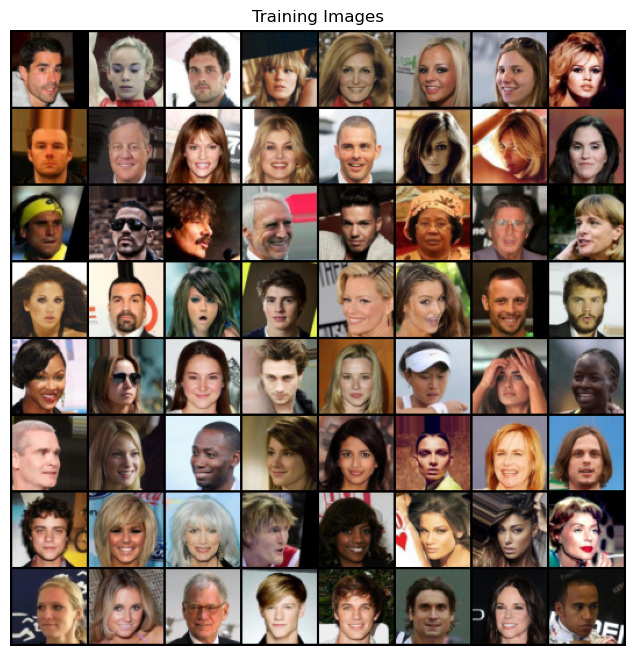

In [4]:
# 학습 데이터들 중 몇가지 이미지들을 화면에 띄워봅시다
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## DCGAN 구현

### 1. 가중치 초기화

In [5]:
# 가중치 초기화: 논문에서는 mean=0, stdev=0.02인 정규분포를 사용한 무작위 초기화 추천
def weight_init(m):
    classname = m.__class__.__name__ # 모듈 m의 class이름 저장
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) # 평균0, 표준편차 0.02의 정규분포로 초기화함
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0) # bias.data를 0으로 초기화



### 2. Generator

- latent vector z를 데이터 공간으로 변환하여 학습 이미지와 같은 사이즈의 RGB 이미지 생성
- 기본적으로 activation function을 RELU를 사용하고, 마지막 출력 계층에서는 tanh를 사용하는데, 이는 출력 값을 [-1, 1] 사이 범위로 조정하기 위함임


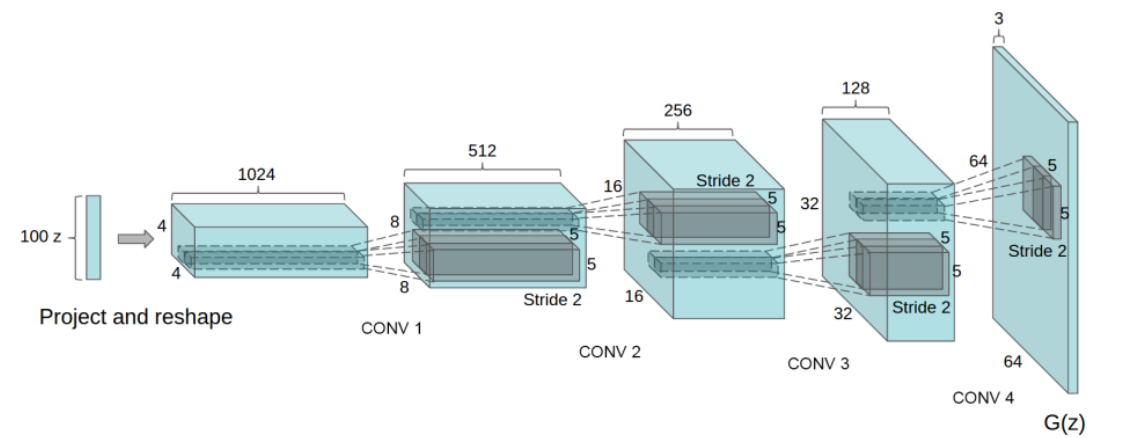


- nz: z 입력 벡터의 길이
- ngf: 생성자를 통과하는 특징 데이터의 크기
- nc: 출력 이미지의 채널 개수(3)

In [ ]:
# generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
             #input, output, kernel_size, stride, padding
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
        # 데이터 크기 (ngf*8*4*4)
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4), # 출력 채널 수 결정
            nn.ReLU(True),
            # ngf*4*4*4

        )